### Preparations

In [1]:
# If on kaggle, copy the contents of the "../input/" directory to the cwd of kaggle
def copy_if_kaggle():
    import os
    import shutil

    if os.getcwd() == "/kaggle/working":
        # Set the source directory
        src_dir = os.path.join("../input", os.listdir("../input")[0])
        # Copy all files from the source directory to the current directory
        for file_name in os.listdir(src_dir):
            shutil.copy(os.path.join(src_dir, file_name), ".")


copy_if_kaggle()
# You can write up to 20GB to the cwd (/kaggle/working) that gets preserved as output when you push a version
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import SplineTransformer
from sklearn import set_config
set_config(transform_output="pandas")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
%matplotlib inline
import seaborn as sns
import plotly.io as pio
pio.templates.default = "plotly_dark"
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
import optuna
# Disable trail logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)
import re

import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PYTHONWARNINGS"] = "ignore"

# %%capture --no-stdout --no-display
# warnings.simplefilter("ignore")

In [3]:
# Plot styling
def my_dark_style():
    from cycler import cycler

    plt.style.use("default")
    plt.style.use(["dark_background", "bmh"])
    plt.rcParams["axes.facecolor"] = "#23272e"
    plt.rcParams["figure.facecolor"] = "#23272e"
    plt.rcParams["axes.prop_cycle"] = cycler(
        "color",
        [
            "#1c90d4",
            "#ad0026",
            "#530fff",
            "#429900",
            "#d55e00",
            "#ff47ac",
            "#42baff",
            "#009e73",
            "#fff133",
            "#0072b2",
        ],
    )
    # plt.rcParams['figure.figsize'] = 9, 7
    plt.rcParams["figure.autolayout"] = True


box_kws = dict(
    boxprops={"edgecolor": "#b2b2b2"},
    capprops={"color": "#b2b2b2"},
    flierprops={"markeredgecolor": "#b2b2b2"},
    medianprops={"color": "#b2b2b2"},
    whiskerprops={"color": "#b2b2b2"},
)
# # plt.rcParams['boxplot.boxprops.edgecolor'] = '#b2b2b2' no such rcParam
# plt.rcParams['boxplot.capprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.flierprops.markeredgecolor'] = '#b2b2b2'
# plt.rcParams['boxplot.medianprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.whiskerprops.color'] = '#b2b2b2'

my_dark_style()

In [4]:
# Load dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


def joint_data():
    return pd.concat([train_data, test_data])


# Store our passenger ID for easy access
PassengerId = test_data.pop("PassengerId")
train_data.drop(columns="PassengerId", inplace=True)

# Initializing random seed (integer) and/or state (instance)
# pass seed to CV splitters (KFold, RepeatedStratifiedKFold, etc.)
seed = 42
# pass rng to estimators and everything else;
# initialize a new rng for each estimator in order to prevent them from influencing each other by consuming the RNG
# rng = np.random.RandomState(seed)
# rng = np.random.default_rng(seed) # new numpy random Generator, not currently supported by sklearn

# If an integer is passed, calling fit or split multiple times always yields the same results.
# If a RandomState instance is passed: fit and split will yield different results each time they are called, and the succession of calls explores all sources of entropy.

# Overview

Nominal: `Survived, Sex, Embarked, Ticket`  
Ordinal: `Pclass`  
Continuous: `Age, Fare`  
Discrete: `SibSp, Parch` 

`Survived` - 0 = No, 1 = Yes  
`Pclass` is the ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd  
`SibSp` is the number of siblings / the number of spouses aboard the Titanic  
`Parch` is the number of parents / the number of children aboard the Titanic  
`Embarked` is the port of embarkation	- C = Cherbourg, Q = Queenstown, S = Southampton  

In [5]:
print(train_data.info())
train_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.000,B42,S
805,0,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.775,NaN,S
549,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.750,NaN,S


In [6]:
print(test_data.info())
test_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB
None


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,1,"Loring, Mr. Joseph Holland",male,30.0,0,0,113801,45.5000,NaN,S
90,3,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judi...",female,22.0,1,0,347072,13.9000,NaN,S
270,1,"McCaffry, Mr. Thomas Francis",male,46.0,0,0,13050,75.2417,C6,C


In [7]:
train_data.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Exploratory Data Analysis and Data Cleaning

### Basic visualizations

Passengers with first-class tickets had the highest survival rate, while those in third class had the lowest survival rate.

<Axes: xlabel='Pclass', ylabel='count'>

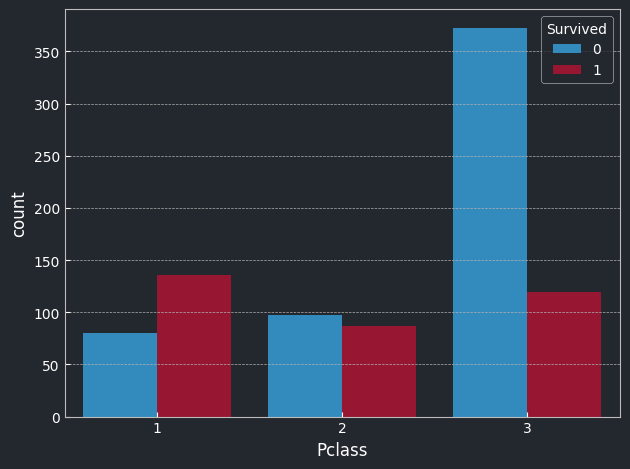

In [8]:
sns.countplot(train_data, x="Pclass", hue="Survived")

 The survival rate of females was significantly higher than that of men.

<Axes: xlabel='Sex', ylabel='count'>

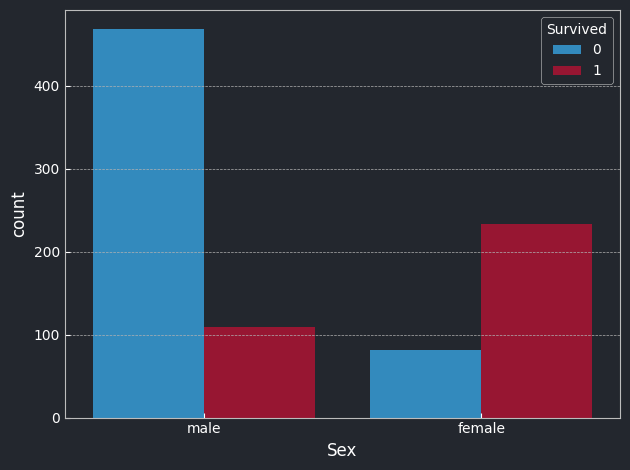

In [9]:
sns.countplot(train_data, x="Sex", hue="Survived")

 Passengers with no siblings/spouses/parents/children on board with them had a lower survival rate than those with a few companions.

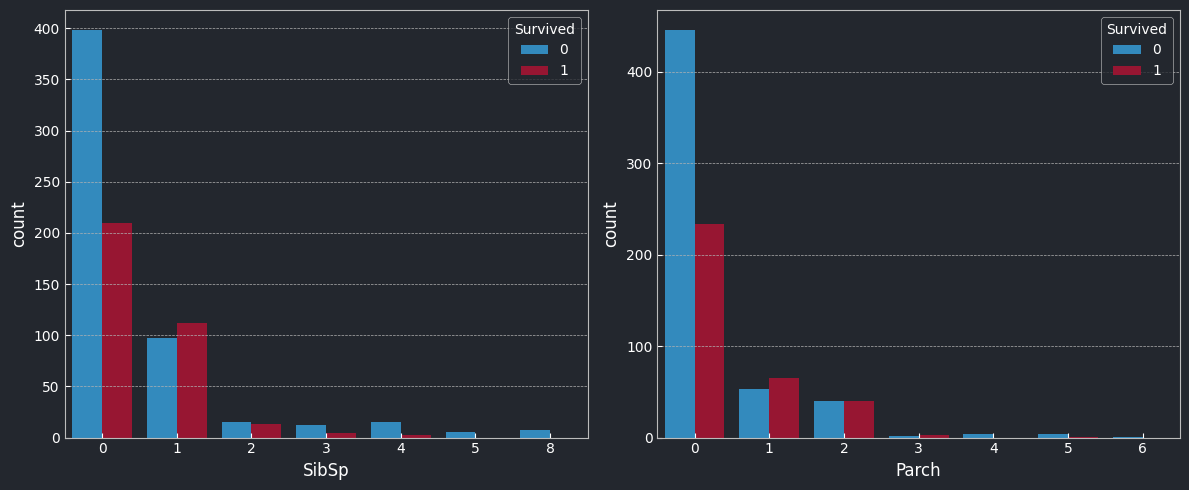

In [10]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in enumerate(["SibSp", "Parch"]):
    sns.countplot(train_data, x=col, hue="Survived", ax=axs[ax])

Those who embarked form the Southampton port had the lowest survival rate. Considering the numbers and order of embarkation (S->C->Q), it is also reasonable to assume that the majority of 3rd class passengers embarked form the Southampton port.

<Axes: xlabel='Embarked', ylabel='count'>

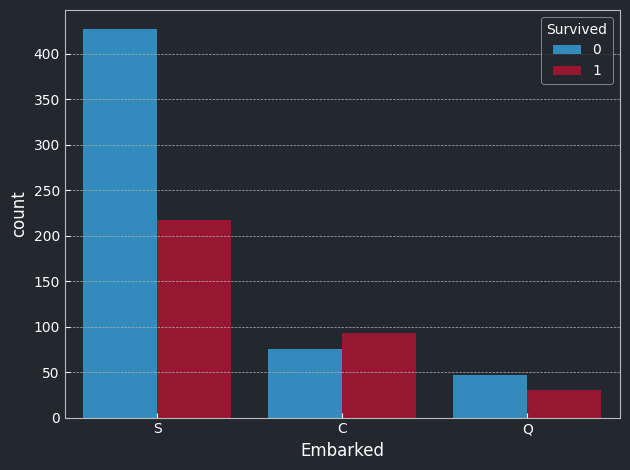

In [11]:
sns.countplot(train_data, x="Embarked", hue="Survived")

Children and elderly passengers had the highest survival rates, whereas those between the age of 20 and 30 had the lowest chance of surviving.

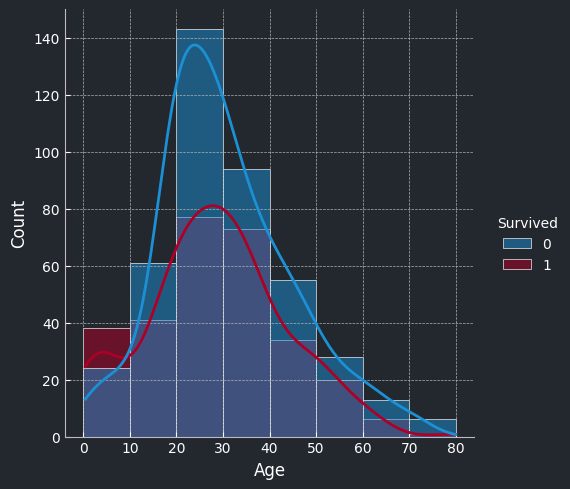

In [12]:
sns.displot(
    train_data, x="Age", hue="Survived", binwidth=10, binrange=(0, 80), kde=True
)

Those with the cheapest tickets had the lowest survival rate. The distribution is strongly skewed to the right. Most tickets cost below 10, and few cost above 100.

Text(0.5, 1.0, 'Log scale')

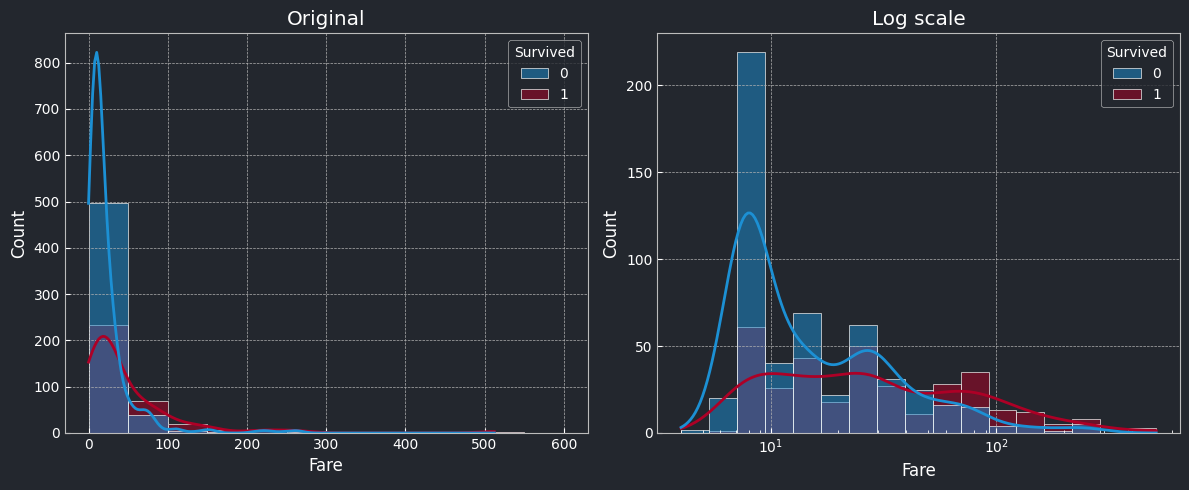

In [13]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data[train_data.Fare > 0],
    x="Fare",
    hue="Survived",
    log_scale=True,
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Log scale")

### Missing values

There are missing values in the `Age, Fare, Cabin` and `Embarked` features. All imputation of missing values is done in a manner that avoids leakage, so some steps are included in a pipeline.

In [14]:
pd.DataFrame(
    [train_data.isna().sum(), test_data.isna().sum()], index=["Train", "Test"]
).T

,Train,Test
Survived,0.0,NaN
Pclass,0.0,0.0
Name,0.0,0.0
Sex,0.0,0.0
Age,177.0,86.0
SibSp,0.0,0.0
Parch,0.0,0.0
Ticket,0.0,0.0
Fare,0.0,1.0
Cabin,687.0,327.0


There is only one passenger with a missing `Fare` value. `Fare` is related to `Pclass`, `Embarked` and family size (`Parch` and `SibSp`) features. Median `Fare` value of a third class ticket with S as the port of embarkation for a passenger with no family is a logical choice to fill the missing value with.


In [15]:
test_data[test_data["Fare"].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [16]:
test_data["Fare"].fillna(
    train_data.groupby(["Pclass", "Parch", "SibSp"]).Fare.median()[3][0][0],
    inplace=True,
)

There are only 2 missing values for `Embarked`. They are filled with the most frequent value.

In [17]:
train_data["Embarked"].fillna(train_data.Embarked.mode()[0], inplace=True)

`Age` missing values are imputed using the median value grouped by `Pclass` and `Sex` (as they are likely indicators of age)

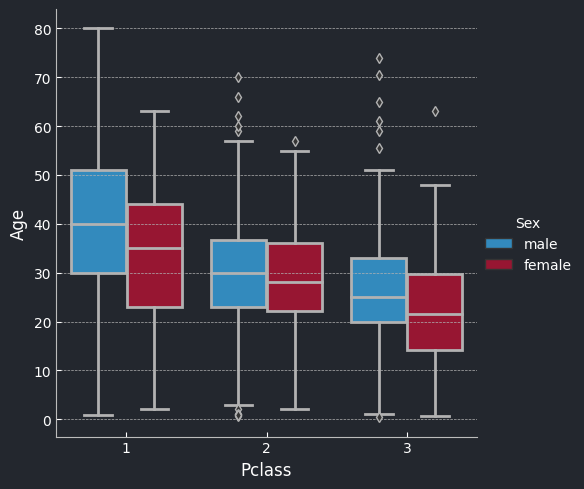

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [18]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        sex_column = [col for col in X.columns if re.match(r"^Sex", col)][0]
        self.age_median_group = X.groupby([sex_column, "Pclass"])["Age"].median()
        return self

    def transform(self, X, y=None):
        sex_column = [col for col in X.columns if re.match(r"^Sex", col)][0]
        X = X.copy()
        X["Age"] = X.apply(
            lambda x: self.age_median_group[x[sex_column], x["Pclass"]]
            if pd.isna(x["Age"])
            else x["Age"],
            axis=1,
        )
        return X


# age_imputer is later included in the pipeline
age_imputer = AgeImputer()
sns.catplot(data=train_data, x="Pclass", y="Age", hue="Sex", kind="box", **box_kws)
plt.show()
age_imputer.fit(train_data).age_median_group

There are far too many missing `Cabin` values to meaningfully impute them, however the feature can't be ignored because some of the cabins might have higher survival rates. Another point of interest is that some passengers had multiple cabins (all on the same deck). Those with several decks paid a significantly higher fare price. Some cabin codes are preceded by an F. It is difficult to determine what this means, but judging by the price, the F is not a separate cabin, so it is removed and treated as a single cabin due to the low number of records containing it.

In [19]:
joint_data()[
    joint_data()["Cabin"].map(lambda x: len(x.split()), na_action="ignore") > 1
].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,0.0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
75,0.0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S
88,1.0,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
97,1.0,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C
118,0.0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C
128,1.0,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
297,0.0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
299,1.0,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C
305,1.0,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,1.0,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


In [20]:
# Remove F_ from cabin codes
for data in [train_data, test_data]:
    data.loc[:, "Cabin"] = data["Cabin"].map(
        (lambda x: x.replace("F ", "")), na_action="ignore"
    )

An extra feature `NCabins` is created which contains the cabin count per passenger.

In [21]:
for data in [train_data, test_data]:
    data.loc[:, "NCabins"] = data["Cabin"].map(
        (lambda x: len(x.split())), na_action="ignore"
    )
    data.NCabins.fillna(1, inplace=True)

joint_data().NCabins.value_counts()

NCabins
1.0    1275
2.0      19
3.0      10
4.0       5
Name: count, dtype: int64

Passengers with multiple cabins have a higher survival rate compared to those with only one cabin.

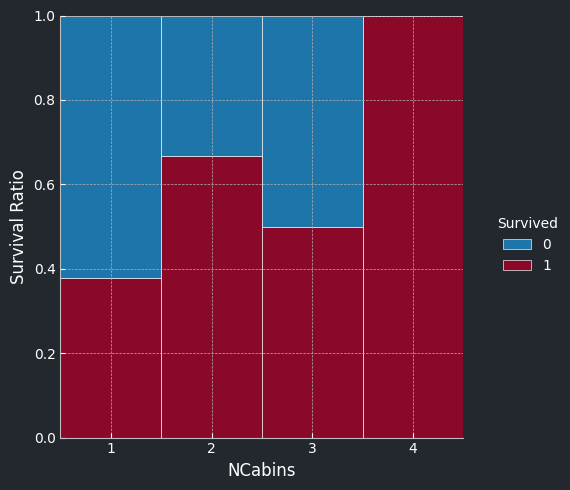

In [22]:
sns.displot(train_data, x="NCabins", hue="Survived", multiple="fill", discrete=True)
plt.ylabel("Survival Ratio")
plt.gca().xaxis.set_major_locator(mplticker.MultipleLocator(1))

In [23]:
for data in [train_data, test_data]:
    data.loc[data.NCabins == 1, "NCabins"] = 0  # one cabin
    data.loc[data.NCabins != 0, "NCabins"] = 1  # multiple cabins

joint_data().NCabins.value_counts()

NCabins
0.0    1275
1.0      34
Name: count, dtype: int64

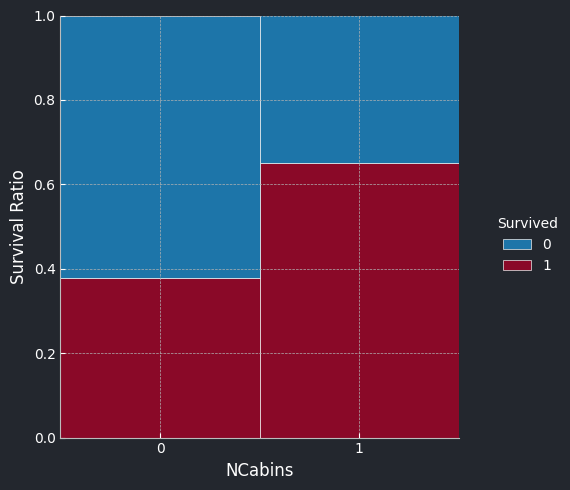

In [24]:
sns.displot(train_data, x="NCabins", hue="Survived", multiple="fill", discrete=True)
plt.ylabel("Survival Ratio")
plt.gca().xaxis.set_major_locator(mplticker.MultipleLocator(1))

The first letter of each cabin code corresponds to the deck level where the cabin is located. `Deck` is extracted from the `Cabin` and the missing values simply encoded as "M". This way the missing values can be dealt with as a separate category of the `Deck` feature by the final model.

In [25]:
for data in [train_data, test_data]:
    data["Cabin"].fillna("M", inplace=True)
    data["Cabin"] = data.Cabin.apply(lambda x: x[0])
    data.rename(columns={"Cabin": "Deck"}, inplace=True)

joint_data().Deck.value_counts()

Deck
M    1014
C      94
B      65
D      46
E      44
A      22
F      14
G       9
T       1
Name: count, dtype: int64

A is the topmost deck, G is the lowest passenger deck, T is the lowest deck of a ship (where the engines and boiler rooms are).  
Passengers on the middle decks B through F had the highest survival rates, whereas those on the lowest passenger deck, and those whose cabin codes are missing, had the lowest survival rate. The only passenger whose cabin was on the Tank Top deck (below the Orlop Deck) did not survive.

Text(15.481746913580247, 0.5, 'Survival Ratio')

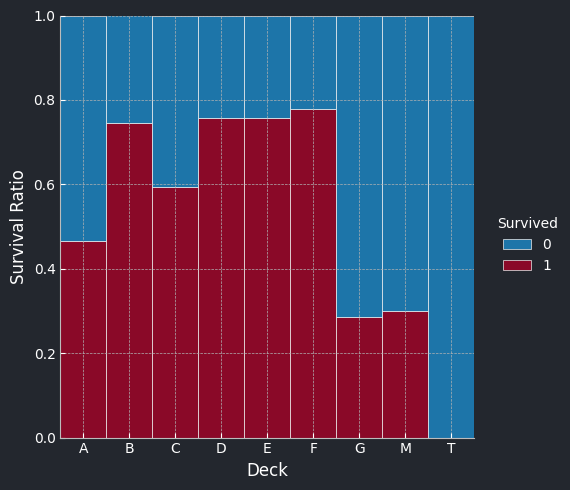

In [26]:
sns.displot(
    train_data.sort_values(by="Deck"), x="Deck", hue="Survived", multiple="fill"
)
plt.ylabel("Survival Ratio")

In [27]:
train_data.Deck.value_counts()

Deck
M    687
C     59
B     47
E     33
D     33
A     15
F      9
G      7
T      1
Name: count, dtype: int64

Considering the distribution of the deck cabins and low sample count, the feature is aggregated into 4 groups to increase the significance of each single group.

In [28]:
for data in [train_data, test_data]:
    data["Deck"] = data["Deck"].replace(["A", "B", "C"], "ABC")
    data["Deck"] = data["Deck"].replace(["D", "E"], "DE")
    data["Deck"] = data["Deck"].replace(["F", "G"], "FG")
    data["Deck"] = data["Deck"].replace("T", "M")

train_data["Deck"].value_counts()

Deck
M      688
ABC    121
DE      66
FG      16
Name: count, dtype: int64

Text(15.481746913580247, 0.5, 'Survival Ratio')

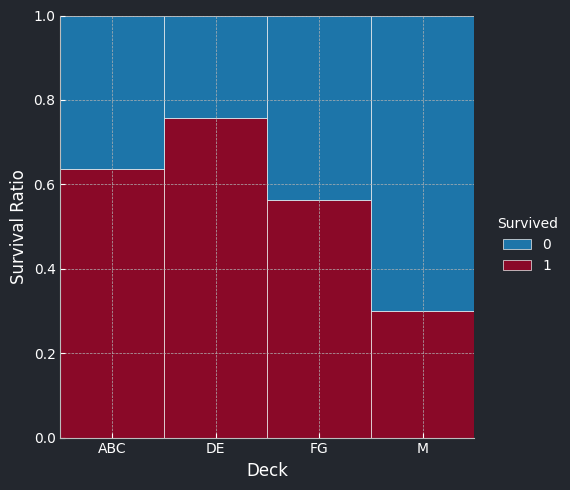

In [29]:
sns.displot(
    train_data.sort_values(by="Deck"), x="Deck", hue="Survived", multiple="fill"
)
plt.ylabel("Survival Ratio")

All missing values have been dealt with.

# Feature Engineering

`Family_Size` is created by adding `SibSp, Parch` and 1, and then aggregated into 4 groups to deal with the high cardinality of the feature in the context of a small dataset. Those who travel entirely alone don't seem to have had the highest chance of survival.

<Axes: xlabel='Family_Size', ylabel='count'>

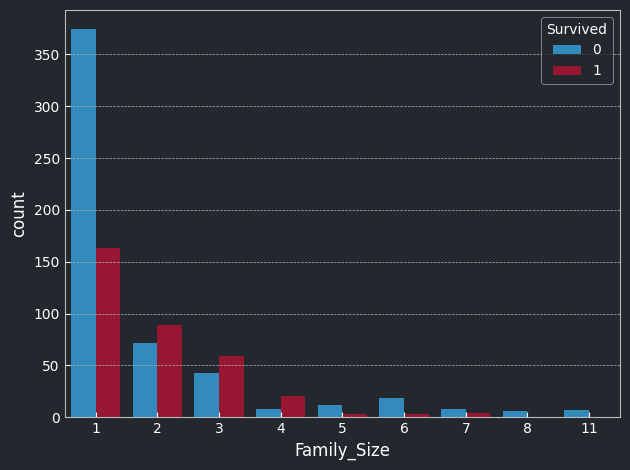

In [30]:
for data in [train_data, test_data]:
    data["Family_Size"] = data.SibSp + data.Parch + 1

sns.countplot(train_data, x="Family_Size", hue="Survived")

In [31]:
mapping = {
    1: 0,  # "Alone"
    2: 1,  # "Small"
    3: 1,  # "Small"
    4: 1,  # "Small"
    5: 2,  # "Medium"
    6: 2,  # "Medium"
    7: 3,  # "Large"
    8: 3,  # "Large"
    11: 3,  # "Large"
}
for data in [train_data, test_data]:
    data.Family_Size.replace(mapping, inplace=True)

([<matplotlib.axis.XTick at 0x7a9385c30760>,
 [Text(0, 0, 'Alone'),
  Text(1, 0, 'Small'),
  Text(2, 0, 'Medium'),
  Text(3, 0, 'Large')])

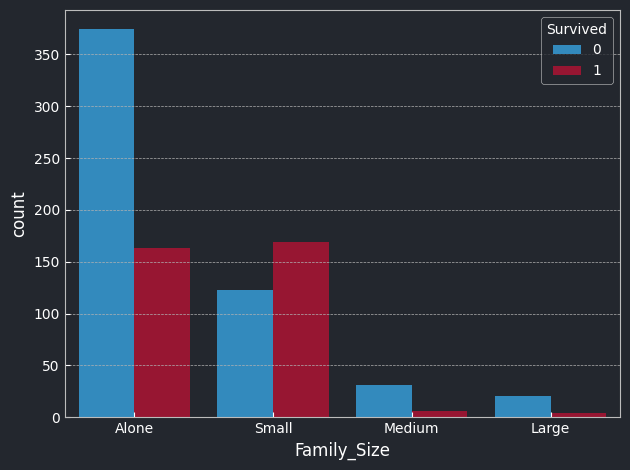

In [32]:
sns.countplot(train_data, x="Family_Size", hue="Survived")
plt.xticks([0, 1, 2, 3], ["Alone", "Small", "Medium", "Large"])

`Ticket_Freq` is created by encoding the frequency with which a ticket occurs, which gives an idea of the size of the group in which one was traveling.

<Axes: xlabel='Ticket_Freq', ylabel='count'>

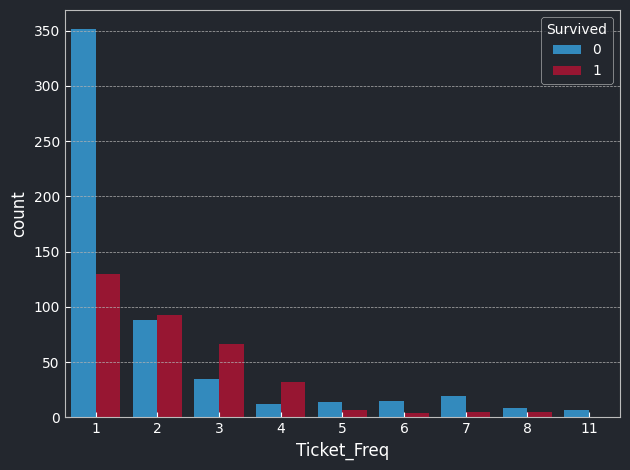

In [33]:
train_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[:891]
)
test_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[891:]
)

sns.countplot(train_data, x="Ticket_Freq", hue="Survived")

`Title` is extracted from the name. All female titles are joined as "Ms", and Male titles with less than 10 samples are joined into a separate category "Other". Those with the title Mr. had the lowest survival rate. Ms. had the highest survival rate. It is noteworthy that those with the "Master" title, though male, also had a high survival rate.

In [34]:
for data in [train_data, test_data]:
    data["Title"] = (
        data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    )
train_data.groupby("Sex").Title.value_counts()

Sex     Title       
female  Miss            182
        Mrs             125
        Mlle              2
        Dr                1
        Lady              1
        the Countess      1
        Ms                1
        Mme               1
male    Mr              517
        Master           40
        Dr                6
        Rev               6
        Col               2
        Major             2
        Jonkheer          1
        Don               1
        Capt              1
        Sir               1
Name: count, dtype: int64

In [35]:
mapping = {
    "Capt": "Other",
    "Col": "Other",
    "Don": "Other",
    "Dona": "Ms",
    "Dr": "Other",
    "Jonkheer": "Other",
    "Lady": "Ms",
    "Major": "Other",
    "Miss": "Ms",
    "Mlle": "Ms",
    "Mme": "Ms",
    "Mrs": "Ms",
    "Ms": "Ms",
    "Rev": "Other",
    "Sir": "Other",
    "the Countess": "Ms",
}
for data in [train_data, test_data]:
    data.Title.replace(mapping, inplace=True)

<Axes: xlabel='Title', ylabel='count'>

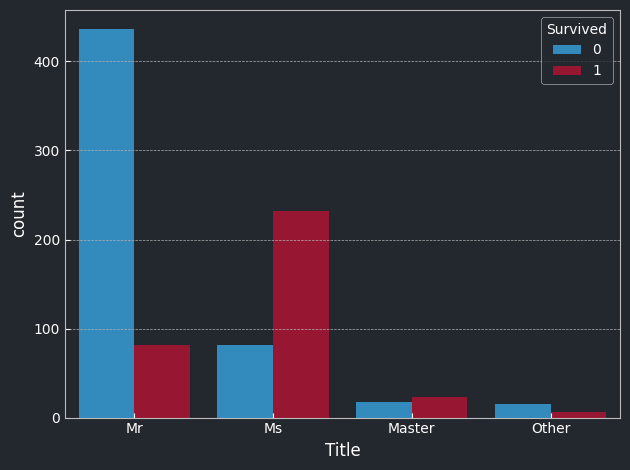

In [36]:
sns.countplot(train_data, x="Title", hue="Survived")

`Name` and `Ticket` are dropped as they are no longer needed and contain no useful information.

In [37]:
for data in [train_data, test_data]:
    data.drop(columns=["Name", "Ticket"], inplace=True)

`Fare` is transformed to log scale to deal with right skewness.

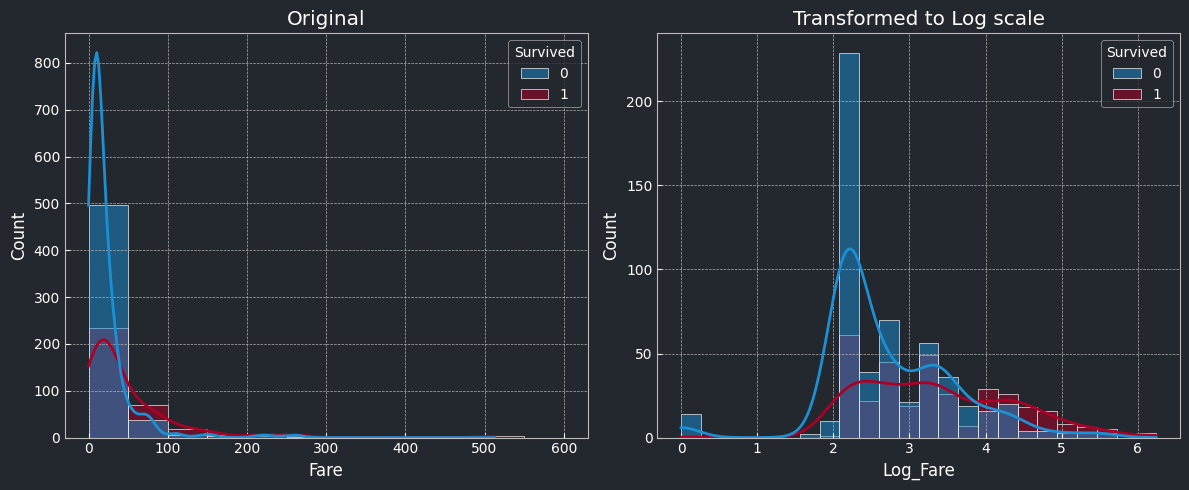

In [38]:
for data in [train_data, test_data]:
    data["Log_Fare"] = np.log1p(data["Fare"])

_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data,
    x="Log_Fare",
    hue="Survived",
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Transformed to Log scale")

for data in [train_data, test_data]:
    data.drop(columns="Fare", inplace=True)

The ratio between the price and quantity could prove to be a useful feature, so it is created by dividing the `Log_Fare` by `Ticket_Freq`.

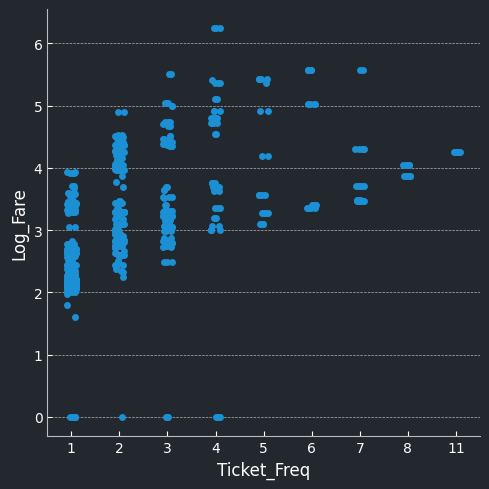

In [39]:
sns.catplot(train_data, x="Ticket_Freq", y="Log_Fare")

<Axes: xlabel='Log_Fare/Ticket_Freq', ylabel='Count'>

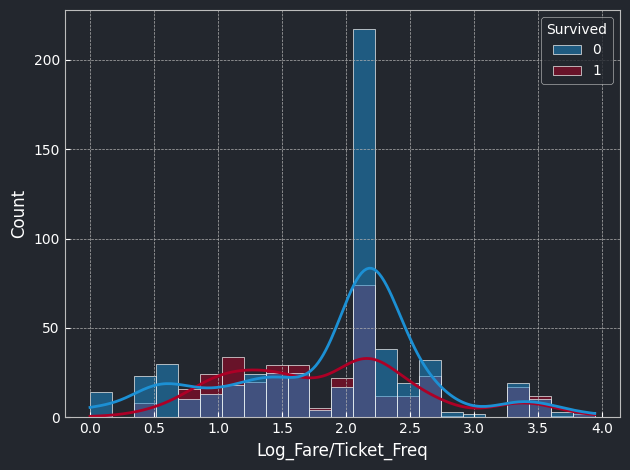

In [40]:
for data in [train_data, test_data]:
    data["Log_Fare/Ticket_Freq"] = data["Log_Fare"] / data["Ticket_Freq"]

sns.histplot(
    train_data,
    x="Log_Fare/Ticket_Freq",
    hue="Survived",
    kde=True,
)

### Encoding

Nominal: `Survived, Sex, Deck, Embarked, NCabins, Title`  
Ordinal: `Pclass, Family_Size`  
Continuous: `Age, Log_Fare, Log_Fare/Ticket_Freq`  
Discrete: `SibSp, Parch, Ticket_Freq` 

In [41]:
# Might come in handy
nominal = ["Survived", "Sex", "Deck", "Embarked", "NCabins", "Title"]
ordinal = ["Pclass", "Family_Size"]
continuous = ["Age", "Log_Fare", "Log_Fare/Ticket_Freq"]
discrete = ["SibSp", "Parch", "Ticket_Freq"]

In [42]:
joint_data().head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Deck,Embarked,NCabins,Family_Size,Ticket_Freq,Title,Log_Fare,Log_Fare/Ticket_Freq
0,0.0,3,male,22.0,1,0,M,S,0.0,1,1,Mr,2.110213,2.110213
1,1.0,1,female,38.0,1,0,ABC,C,0.0,1,2,Ms,4.280593,2.140297
2,1.0,3,female,26.0,0,0,M,S,0.0,0,1,Ms,2.188856,2.188856
3,1.0,1,female,35.0,1,0,ABC,S,0.0,1,2,Ms,3.990834,1.995417
4,0.0,3,male,35.0,0,0,M,S,0.0,0,1,Mr,2.202765,2.202765


All features except `Sex, Deck, Embarked` and `Title` are already properly encoded, so only they are encoded (as a one-hot numeric array).

In [43]:
feat = ["Sex", "Deck", "Embarked", "Title"]
ohe = OneHotEncoder(drop="if_binary", sparse_output=False)
train_data = train_data.drop(columns=feat).join(ohe.fit_transform(train_data[feat]))
test_data = test_data.drop(columns=feat).join(ohe.transform(test_data[feat]))

joint_data().info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              891 non-null    float64
 1   Pclass                1309 non-null   int64  
 2   Age                   1046 non-null   float64
 3   SibSp                 1309 non-null   int64  
 4   Parch                 1309 non-null   int64  
 5   NCabins               1309 non-null   float64
 6   Family_Size           1309 non-null   int64  
 7   Ticket_Freq           1309 non-null   int64  
 8   Log_Fare              1309 non-null   float64
 9   Log_Fare/Ticket_Freq  1309 non-null   float64
 10  Sex_male              1309 non-null   float64
 11  Deck_ABC              1309 non-null   float64
 12  Deck_DE               1309 non-null   float64
 13  Deck_FG               1309 non-null   float64
 14  Deck_M                1309 non-null   float64
 15  Embarked_C            1309 

### Dealing with Multicollinearity

In [44]:
# Define transformer class for filtering out highly correlated features and plotting correlation
# turns out this isn't very computationally efficient.. tuning hyperparameters takes too long
class SelectCorrelationClusters(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        threshold=0.7,
        corr_method="spearman",
        linkage_method="ward",
        optimal_ordering=True,
    ):
        self.threshold = threshold
        self.corr_method = corr_method
        self.linkage_method = linkage_method
        self.optimal_ordering = optimal_ordering

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Remove constant columns and calculate correlation
        self.constant_cols = np.where(X.nunique() == 1)[0]
        self.corr_ = X.drop(columns=X.columns[self.constant_cols]).corr(
            method=self.corr_method
        )
        # Convert the correlation matrix to a distance matrix before performing hierarchical clustering
        distance_matrix = 1 - self.corr_.abs()
        self.Z = linkage(
            squareform(distance_matrix, checks=False),
            "ward",
            optimal_ordering=self.optimal_ordering,
        )
        # Extract the cluster labels for each feature based on the specified threshold
        clusters = fcluster(self.Z, self.threshold, criterion="distance")
        # Filter out highly correlated features
        # Keep one feature per cluster with the maximum average correlation
        self.kept_features = []
        for cluster_id in set(clusters):
            clusters_boolean = clusters == cluster_id
            corr_vals = self.corr_.iloc[clusters_boolean, clusters_boolean]
            best_feature_idx = corr_vals.abs().sum(axis=1).idxmax()
            self.kept_features.append(corr_vals.columns.get_loc(best_feature_idx))
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        return X.drop(columns=X.columns[self.constant_cols]).iloc[:, self.kept_features]

    def plot(self, annot=True, cmap="RdBu", split=True):
        if not split:
            # Plot clustermap
            sns.clustermap(
                self.corr_.round(2),
                row_linkage=self.Z,
                col_linkage=self.Z,
                cmap=cmap,
                annot=annot,
                annot_kws={"size": 8},
                vmin=-1,
                vmax=1,
                figsize=(15, 12),
                dendrogram_ratio=0.2,
            )
        else:
            # Plot dendrogram with correlation heatmap
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))
            dendro = dendrogram(
                self.Z,
                labels=self.corr_.columns,
                ax=ax1,
                leaf_rotation=90,
            )
            order = dendro["leaves"]
            sns.heatmap(
                self.corr_.iloc[order, order],
                cmap=cmap,
                annot=annot,
                vmin=-1,
                vmax=1,
                # linewidths=0.01,
                # linecolor="#23272e",
                ax=ax2,
            )
            fig.tight_layout()
        plt.show()


def calculate_vif(X):
    # Add constant column
    # X = add_constant(X)
    X = X.assign(const=1)

    # Calculate VIF for each variable
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

When a dummy variable that represents more than two categories has a high VIF score, multicollinearity does not necessarily exist. The variables will always have high VIFs if there is a small portion of cases in the category, regardless of whether the categorical variables are correlated to other variables, so dummy encoded nominal variables are ignored.  
`Family_Size, SibSp` and `Parch` have an infinite VIF score and are perfectly multicollinear. They all have high correlation scores, along with `Ticket_Freq`. Considering their MI scores, `Family_Size` is kept and the rest are dropped, along with `Log_Fare`, which also has high correlation scores with those previously mentioned and with `Log_Fare/Ticket_Freq`, with the exception that it also has high correlation with `Pclass` (which the rest do not), which results in a higher VIF score than `Log_Fare/Ticket_Freq`.

In [45]:
# impd_age is needed to demonstrate how things work with imputed age values,
# which will actually be imputed later, during CV
impd_age = age_imputer.fit_transform(train_data)

,Variable,VIF
0,SibSp,7.760575
1,Parch,4.209701
2,Ticket_Freq,9.068345
3,Age,1.345696
4,Log_Fare,4.475508
5,Log_Fare/Ticket_Freq,3.806388
6,Pclass,2.679046
7,Family_Size,10.326209
8,const,108.652227


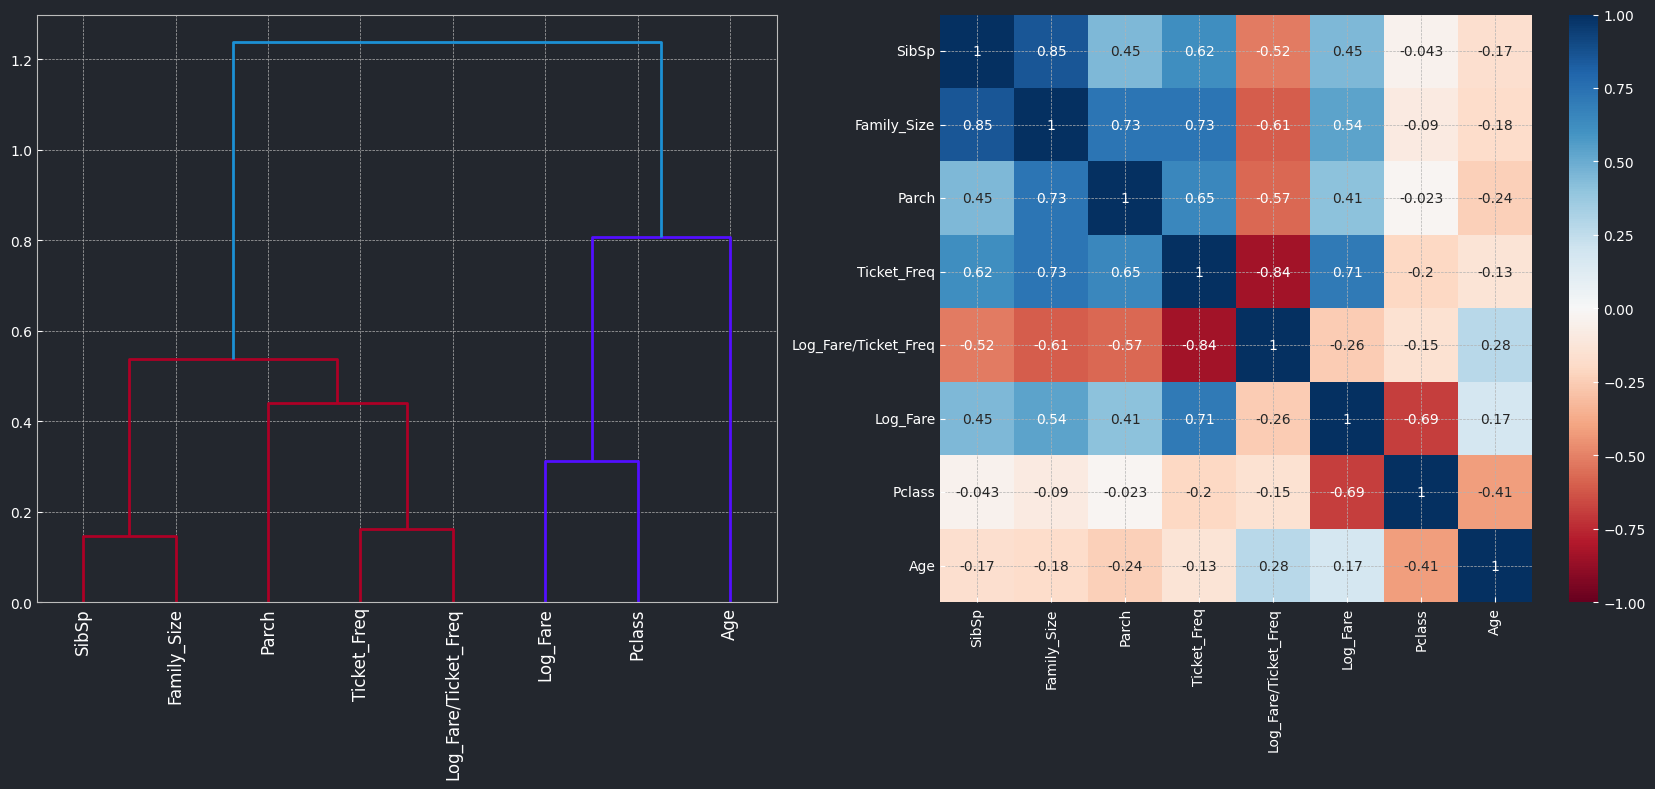

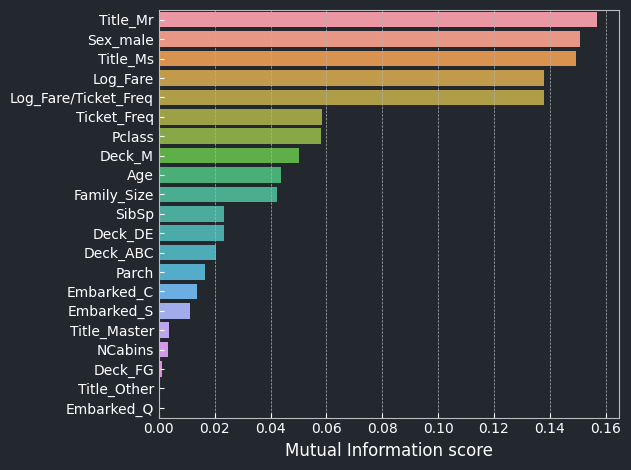

In [46]:
display(calculate_vif(impd_age[discrete + continuous + ordinal]))
SelectCorrelationClusters().fit(impd_age[discrete + continuous + ordinal]).plot()
mutinf = pd.Series(
    mutual_info_classif(
        impd_age.drop(columns="Survived"),
        impd_age["Survived"],
        discrete_features=[
            True
            if col
            not in [
                "Age",
                "Log_Fare",
                "Log_Fare/Ticket_Freq",
            ]
            else False
            for col in impd_age.drop(columns="Survived").columns
        ],
        random_state=seed,
    ),
    index=impd_age.drop(columns="Survived").columns,
).sort_values(ascending=False)
sns.barplot(x=mutinf, y=mutinf.index.astype(str))
plt.xlabel("Mutual Information score")
plt.tight_layout()
plt.show()

In [47]:
for data in [train_data, test_data]:
    data.drop(
        columns=[
            "SibSp",
            "Parch",
            "Ticket_Freq",
            "Log_Fare",
        ],
        inplace=True,
    )

# Might come in handy
nominal = ["Survived", "Sex", "Deck", "Embarked", "NCabins", "Title"]
ordinal = ["Pclass", "Family_Size"]
continuous = ["Age", "Log_Fare/Ticket_Freq"]
discrete = []

Now all VIF scores are within reasonable bounds.

In [48]:
calculate_vif(impd_age[discrete + continuous + ordinal])

,Variable,VIF
0,Age,1.334570
1,Log_Fare/Ticket_Freq,1.737005
2,Pclass,1.274188
3,Family_Size,1.606845
4,const,40.087149


### Reciprocal

Next the multiplicative inverse of ordinal/continuous/discrete features is added.

In [49]:
# class ReciprocalTransformer(BaseEstimator, TransformerMixin):
#     def get_thresholds(self, column):
#         # Find the minimum positive non-zero value (value closest to zero) in the column
#         min_nonzero = np.min(column[column != 0].abs())
#         # Calculate the closest 10^n value below the minimum non-zero value in the column
#         self.threshold[column.name] = 10 ** np.floor(np.log10(min_nonzero))

#     def transform_zeros(self, column):
#         column_values = column.copy()
#         # Find zero values in the column and replace them with the threshold value
#         column_values.loc[column_values == 0] = self.threshold[column_values.name]
#         return column_values

#     def fit(self, X, y=None):
#         # Store thresholds by column name
#         self.threshold = {}
#         # Exclude columns that are OHE dummies
#         self.selected_columns = X.loc[
#             :, ~np.all(np.logical_or(X == 0, X == 1), axis=0)
#         ].columns
#         # Get thresholds
#         X[self.selected_columns].apply(self.get_thresholds)
#         return self

#     def transform(self, X, y=None):
#         # Apply the transform_zeros function to each selected column
#         transformed_columns = X[self.selected_columns].apply(self.transform_zeros)
#         # Take the reciprocal of the transformed columns
#         reciprocals = 1 / transformed_columns
#         return X.join(reciprocals, rsuffix="_inverse")


# ReciprocalTransformer().fit(train_data).transform(train_data).filter(
#     regex="_inverse$"
# ).head()

# Model training and selection

The data is prepared along with a function for calculating mutual information between the dependent and independent variables for feature selection.

In [50]:
# Prepare data
X = train_data.copy()
y = X.pop("Survived")

# Define score function to go into SelectKBest
discrete_features = [
    True
    if col
    not in [
        "Age",
        "Log_Fare/Ticket_Freq",
    ]
    else False
    for col in X.columns
]


def mut_info(X, y):
    return mutual_info_classif(
        X,
        y,
        discrete_features=discrete_features,
        random_state=seed,
    )


# # Define transformer to clean up after adding feature interactions and standardizing
# class RemoveDuplicates(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         df = pd.DataFrame(X)
#         self.not_dup = list(df.columns[~df.T.duplicated()])
#         return self

#     def transform(self, X):
#         df = pd.DataFrame(X)
#         return df.loc[:, self.not_dup]  # .to_numpy()


# # Define function to create a DataFrame from top scores
# def get_top_scores(study, score_count=7):
#     df = (
#         study.trials_dataframe(attrs=("value", "duration", "params"))
#         .sort_values(by="value", ascending=False)
#         .head(score_count)
#     ).rename(
#         columns=lambda x: re.sub(r"^params_", "", x)
#     )  # remove params_ from col names
#     df["duration"] = df["duration"].dt.total_seconds()
#     return df

Pipeline steps are initialized and passed to the `cv_pipe` function which takes an optuna `trial` and the `model` to by optimized and returns a score used by optuna for hyperparameter optimization.

In [51]:
# Initialize pipeline steps
age_imputer = AgeImputer()
standardize = StandardScaler()
to_spline = make_column_selector(pattern=r"Age|Log_Fare\/Ticket_Freq")
splines = ColumnTransformer(
    [
        (
            "splines",
            SplineTransformer(
                n_knots=3,
                degree=3,
                extrapolation="linear",
                knots="quantile",
            ),
            to_spline,
        )
    ],
    remainder="passthrough",
)

In [52]:
# Define the objective of the study without the model
def cv_pipe(trial, model, X, y):
    # Create Pipeline
    pipe = make_pipeline(
        age_imputer,
        SelectKBest(mut_info, k=trial.suggest_int("k_best", 7, 17)),
        splines,
        standardize,
        model,
    )

    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score

A function is defined which takes an optuna compatible objective function and performs nested cross-validation for the given model, populating the global `model_results` DataFrame. The procedure involves treating model hyperparameter optimization as part of the model itself and evaluating it within the broader k-fold cross-validation procedure for evaluating models for comparison and selection. As such, the k-fold cross-validation procedure for model hyperparameter optimization is nested inside the k-fold cross-validation procedure for model selection.

In [53]:
# Function to perform nested cross-validation of objective function using optuna for hyperparameter optimization
def perform_nested_cv(
    objective,
    X,
    y,
    n_trials=300,
    study_timeout=700,
    n_splits=4,
    n_repeats=1,
    random_state=seed,
):
    print("Inner loop:\n")
    # Outer cross-validation
    cv_scores = []
    outer_scores = []
    outer_cv = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    split_n = 1
    for i, (train_index, test_index) in enumerate(outer_cv.split(X, y), 1):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Define unique identifier of the study
        study_name = f"{model.__class__.__name__}_split_{i}"
        study = optuna.create_study(
            storage=storage_name,
            study_name=study_name,
            sampler=optuna.samplers.TPESampler(
                multivariate=False, seed=seed, warn_independent_sampling=False
            ),
            direction="maximize",
            load_if_exists=True,
        )

        # Perform hyperparameter optimization (with inner cross-validation)
        study.optimize(
            lambda trial: objective(trial, X_train_outer, y_train_outer),
            n_trials=n_trials,
            timeout=study_timeout,
            catch=(ValueError),
            # callbacks=[logging_callback],
        )
        cv_scores.append(study.best_value)
        print(f"    {study_name}")
        split_n += 1

        # Select and assign best hyperparameters
        best_study_params_ = study.best_params
        print(f"    Best params: {best_study_params_}")
        k_best = best_study_params_.pop("k_best")
        # Assign model parameters to estimator
        model.set_params(**best_study_params_)
        # Create pipeline
        pipe = make_pipeline(
            age_imputer,
            SelectKBest(mut_info, k=k_best),
            splines,
            standardize,
            model,
        )

        # Refit the model with best hyperparameters on entire outer training data
        pipe.fit(X_train_outer, y_train_outer)

        # Evaluate on the outer test set
        score = pipe.score(X_test_outer, y_test_outer)
        outer_scores.append(score)
        print(
            f"    inner CV score: {study.best_value:.3f} | outer test score: {score:.3f}\n"
        )
    nest_mean, nest_std, inner_mean, inner_std = (
        np.mean(outer_scores),
        np.std(outer_scores),
        np.mean(cv_scores),
        np.std(cv_scores),
    )
    model_results.loc[model.__class__.__name__] = [
        nest_mean,
        nest_std,
        inner_mean,
        inner_std,
    ]
    print(
        f"Outer loop:\n\n    mean outer test score: {np.mean(outer_scores):.3f} +/- {np.std(outer_scores):.3f}"
    )
    # return outer_scores

Preparations are made to run the nested cross-validations and store the results.

In [54]:
# Define DB file name for storing tuning results
db_name = "nested_titanic_study"
storage_name = f"sqlite:///{db_name}.db"

# Create DataFrame to store results of model evaluations
model_results = pd.DataFrame(
    columns=[
        "mean_nested_CV",
        "std_nested_CV",
        "mean_inner_CV",
        "std_inner_CV",
    ]
)
model_results.index.name = "Algorithm"

# Turn off optuna log notes.
optuna.logging.set_verbosity(optuna.logging.WARN)


# Define a function to output a log only when the best value is updated
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            f"Trial {frozen_trial.number} finished with best value: {frozen_trial.value} and parameters: {frozen_trial.params}.\n"
        )

Nested cross-validation is performed for a number of classification algorithms.

### K-Nearest Neighbours

In [55]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = KNeighborsClassifier(
    n_jobs=-1,
)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(n_neighbors=trial.suggest_int("n_neighbors", 4, 40))
    return cv_pipe(trial, model, X, y)

In [56]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    KNeighborsClassifier_split_1
    Best params: {'n_neighbors': 5, 'k_best': 7}
    inner CV score: 0.815 | outer test score: 0.825

    KNeighborsClassifier_split_2
    Best params: {'n_neighbors': 14, 'k_best': 7}
    inner CV score: 0.820 | outer test score: 0.812

    KNeighborsClassifier_split_3
    Best params: {'n_neighbors': 5, 'k_best': 11}
    inner CV score: 0.820 | outer test score: 0.812

    KNeighborsClassifier_split_4
    Best params: {'n_neighbors': 14, 'k_best': 10}
    inner CV score: 0.832 | outer test score: 0.815

Outer loop:

    mean outer test score: 0.816 +/- 0.006


### Random Forest

In [57]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = RandomForestClassifier(n_jobs=-1, random_state=rng)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        max_depth=trial.suggest_int("max_depth", 5, 21),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 5, 55),
        max_features=trial.suggest_float("max_features", 0.1, 0.9),
        ccp_alpha=trial.suggest_float("ccp_alpha", 1e-9, 0.1, log=True),
    )
    return cv_pipe(trial, model, X, y)

In [58]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    RandomForestClassifier_split_1
    Best params: {'max_depth': 9, 'min_samples_leaf': 5, 'max_features': 0.1425503053253092, 'ccp_alpha': 1.0688983161648388e-09, 'k_best': 17}
    inner CV score: 0.828 | outer test score: 0.852

    RandomForestClassifier_split_2
    Best params: {'max_depth': 11, 'min_samples_leaf': 9, 'max_features': 0.15151101456349672, 'ccp_alpha': 0.008748833370387782, 'k_best': 16}
    inner CV score: 0.840 | outer test score: 0.816

    RandomForestClassifier_split_3
    Best params: {'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 0.5955182075081175, 'ccp_alpha': 2.399596071761771e-05, 'k_best': 8}
    inner CV score: 0.831 | outer test score: 0.825

    RandomForestClassifier_split_4
    Best params: {'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 0.8763744365952749, 'ccp_alpha': 9.238224427000926e-09, 'k_best': 17}
    inner CV score: 0.844 | outer test score: 0.851

Outer loop:

    mean outer test score: 0.836 +/- 0.016


### Support Vector Machine

In [59]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = SVC(gamma="scale", max_iter=100000, random_state=rng, cache_size=1000)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        C=trial.suggest_float("C", 1e-4, 1000, log=True),
        kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
    )
    return cv_pipe(trial, model, X, y)

In [60]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    SVC_split_1
    Best params: {'C': 0.7343063761035631, 'kernel': 'linear', 'k_best': 17}
    inner CV score: 0.826 | outer test score: 0.843

    SVC_split_2
    Best params: {'C': 4.801074150669438, 'kernel': 'linear', 'k_best': 15}
    inner CV score: 0.835 | outer test score: 0.812

    SVC_split_3
    Best params: {'C': 0.3387362658100166, 'kernel': 'linear', 'k_best': 17}
    inner CV score: 0.829 | outer test score: 0.834

    SVC_split_4
    Best params: {'C': 4.120335717148756, 'kernel': 'rbf', 'k_best': 14}
    inner CV score: 0.841 | outer test score: 0.824

Outer loop:

    mean outer test score: 0.828 +/- 0.012


### AdaBoost

In [61]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=rng)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        # estimator__max_depth=trial.suggest_int("estimator__max_depth", 1, 3),
        n_estimators=trial.suggest_int("n_estimators", 10, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-7, 1, log=True),
    )
    return cv_pipe(trial, model, X, y)

In [62]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    AdaBoostClassifier_split_1
    Best params: {'n_estimators': 74, 'learning_rate': 0.004501696805100708, 'k_best': 7}
    inner CV score: 0.803 | outer test score: 0.852

    AdaBoostClassifier_split_2
    Best params: {'n_estimators': 22, 'learning_rate': 0.005918147240280267, 'k_best': 7}
    inner CV score: 0.801 | outer test score: 0.794

    AdaBoostClassifier_split_3
    Best params: {'n_estimators': 14, 'learning_rate': 0.01296277836076618, 'k_best': 17}
    inner CV score: 0.797 | outer test score: 0.767

    AdaBoostClassifier_split_4
    Best params: {'n_estimators': 97, 'learning_rate': 0.32702845450377893, 'k_best': 7}
    inner CV score: 0.800 | outer test score: 0.824

Outer loop:

    mean outer test score: 0.809 +/- 0.032


### Gradient Boosting

In [63]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = GradientBoostingClassifier(
    random_state=rng,
)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        n_estimators=trial.suggest_int("n_estimators", 30, 400),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1, log=True),
        subsample=trial.suggest_float("subsample", 0.1, 1),
        min_samples_split=trial.suggest_float("min_samples_leaf", 1e-3, 1e-1, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 30),
        max_features=trial.suggest_float("max_features", 0.1, 0.9),
        ccp_alpha=trial.suggest_float("ccp_alpha", 1e-9, 0.1),
    )
    return cv_pipe(trial, model, X, y)

In [64]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    GradientBoostingClassifier_split_1
    Best params: {'n_estimators': 178, 'learning_rate': 0.009067463228462079, 'subsample': 0.4270015710684349, 'min_samples_leaf': 0.0032574780018115542, 'max_depth': 29, 'max_features': 0.1514086427845887, 'ccp_alpha': 0.0018959787373421624, 'k_best': 17}
    inner CV score: 0.835 | outer test score: 0.843

    GradientBoostingClassifier_split_2
    Best params: {'n_estimators': 397, 'learning_rate': 0.0037298561219179524, 'subsample': 0.8805396687243503, 'min_samples_leaf': 0.0036605788330641305, 'max_depth': 4, 'max_features': 0.4721190504234472, 'ccp_alpha': 0.00223954506720546, 'k_best': 17}
    inner CV score: 0.833 | outer test score: 0.812

    GradientBoostingClassifier_split_3
    Best params: {'n_estimators': 157, 'learning_rate': 0.028220740471892707, 'subsample': 0.34629502982726396, 'min_samples_leaf': 0.037454705743499586, 'max_depth': 8, 'max_features': 0.11546223313483767, 'ccp_alpha': 0.0022899466569018443, 'k_best':

### XGBoost

In [65]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = XGBClassifier(booster="gbtree", random_state=rng, verbosity=0)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        n_estimators=trial.suggest_int("n_estimators", 30, 500),
        eta=trial.suggest_float("eta", 1e-4, 1),
        subsample=trial.suggest_float("subsmaple", 0.1, 1),
        max_depth=trial.suggest_int("max_depth", 3, 55),
        min_child_weight=trial.suggest_float("min_child_weight", 1e-3, 10),
        scale_pos_weight=trial.suggest_float(
            "scale_pos_weight", 0.56, 0.69
        ),  # (negative instances/positive instances) +/- 10%
        reg_alpha=trial.suggest_float("reg_alpha", 0, 100),
    )
    return cv_pipe(trial, model, X, y)

In [66]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    XGBClassifier_split_1
    Best params: {'n_estimators': 51, 'eta': 0.8644818354786413, 'subsmaple': 0.8751071665051908, 'max_depth': 19, 'min_child_weight': 0.43365187978566533, 'scale_pos_weight': 0.583998684068393, 'reg_alpha': 5.72258855877472, 'k_best': 17}
    inner CV score: 0.835 | outer test score: 0.861

    XGBClassifier_split_2
    Best params: {'n_estimators': 257, 'eta': 0.629565393561576, 'subsmaple': 0.8505750237119691, 'max_depth': 10, 'min_child_weight': 0.22818769730469673, 'scale_pos_weight': 0.5894764049371617, 'reg_alpha': 3.515758077055473, 'k_best': 17}
    inner CV score: 0.835 | outer test score: 0.821

    XGBClassifier_split_3
    Best params: {'n_estimators': 81, 'eta': 0.8612053373749055, 'subsmaple': 0.7980923757722104, 'max_depth': 32, 'min_child_weight': 0.4816345069369561, 'scale_pos_weight': 0.5925369673585706, 'reg_alpha': 5.794879524402771, 'k_best': 10}
    inner CV score: 0.823 | outer test score: 0.816

    XGBClassifier_split_4
 

The results of the nested cross-validation show that the RandomForestClassifier algorithm has the highest accuracy score on held out test data.

In [67]:
model_results.sort_values(by="mean_nested_CV", ascending=False)

,mean_nested_CV,std_nested_CV,mean_inner_CV,std_inner_CV
Algorithm,,,,
RandomForestClassifier,0.836156,0.015851,0.835579,0.006469
XGBClassifier,0.833899,0.017611,0.832769,0.006167
GradientBoostingClassifier,0.830536,0.011907,0.836329,0.003547
SVC,0.828278,0.011658,0.832767,0.005793
KNeighborsClassifier,0.815936,0.005504,0.821921,0.006114
AdaBoostClassifier,0.809220,0.032008,0.800230,0.002149


# Final Model

After extensive tuning, the final model resulted in an out of bag (OOB) accuracy score of ≈0.81.

In [68]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=21,
    min_samples_leaf=43,
    max_features=0.11,
    ccp_alpha=0.0001,
    n_jobs=-1,
    random_state=rng,
    oob_score=True,
)
# Create Pipeline
pipe = make_pipeline(
    age_imputer,
    SelectKBest(mut_info, k=8),
    splines,
    model,
)

In [69]:
# Train model and generate predictions
predictions = pipe.fit(X, y).predict(test_data)
# Create submission CSV
predictions_df = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions})
predictions_df.to_csv("submission.csv", header=True, index=False)
print(f"Out of Bag (OOB) accuracy score: {model.oob_score_}")

Out of Bag (OOB) accuracy score: 0.8114478114478114


The `Log_Fare/Ticket_Freq` feature tuned out to be the most important among all features, followed by the title, sex and age features. The `Embarked` feature was removed entirely by the pipeline, as it didn't prove useful to the final score. Note, that the total number of features supplied to the model is actually 16, after the spline transformation of continuous features is applied.

In [70]:
# Calculate permutation importance scores
perm_pipe = permutation_importance(
    pipe, X, y, random_state=seed, n_repeats=10, n_jobs=-1
)
perm_imp = (
    pd.DataFrame(perm_pipe.importances, index=X.columns)
    .reset_index()
    .melt(id_vars="index")
)
# Filter out features removed by SelectKBest
perm_imp = perm_imp.groupby("index").filter(lambda group: group["value"].mean() > 0)

<Axes: xlabel='value', ylabel='index'>

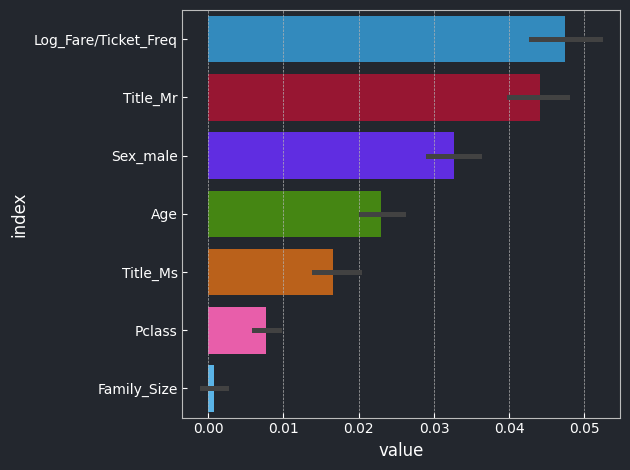

In [71]:
# Plot importance scores
sns.barplot(
    perm_imp,
    x="value",
    y="index",
    order=perm_imp.groupby("index")["value"].mean().sort_values(ascending=False).index,
)

In [72]:
model.n_features_in_

16

Uncomment and run the following to open a real-time dashboard for Optuna (via your browser of choice) which contains detailed information about all trials for conveniently exploring the optimization history, hyperparameter importances, etc. in graphs and tables.

In [73]:
# !optuna-dashboard sqlite:///nested_titanic_study.db

Or execute the above command in a terminal (without the exclamation mark), and run the following cell to view the dashboard directly from within this notebook.

In [74]:
# %%html
# <iframe src="http://127.0.0.1:8080/" width="1330" height="550"></iframe>